In [1]:
import spacy
from spacy import displacy

import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [125]:
# Using word2vec with gensim
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [124]:
def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Not sold')
            green_patch = mpatches.Patch(color='blue', label='Sold')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Not sold', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Sold', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

    
def get_average_word2vec(tokens_list, vector, print_missing=False, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = []
        for word in tokens_list:
            if word in vector:
                vectorized.append(vector[word])
            else:
                vectorized.append(np.zeros(k))
                if print_missing:
                    print('Token not recognized : {}'.format(word))
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return max(vectorized)


# Load description data, and drop examples without description

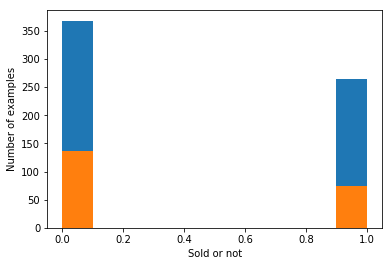

In [4]:
df = pd.read_csv('hack_train.csv', header=0, sep=';', error_bad_lines=False, encoding='utf8')
data = df[['description', 'sold']].dropna()

descriptions = data['description'].values


# Transform descriptions to vectors

#### Bag of words technique

In [118]:
# Using bag of words technique

vec = CountVectorizer()#ngram_range=(2,3))#, analyzer='char_wb', stop_words='english')
transformer = TfidfTransformer()

x = vec.fit_transform(descriptions)
x = transformer.fit_transform(x)
y = data['sold'].values

#### Using word2vec technique with spacy
Basically transforms every word (token) in a vector, and get the description vector with an average

In [105]:
# Using word2vec with spacy

nlp = spacy.load('en')

x = []
for description in descriptions:
    description_vect = nlp(description).vector # by default, average of all tokens vectors
    x.append(description_vect)

x = np.array(x)
y = data['sold'].values
#displacy.render(doc, style='dep', jupyter=True)

#### Using word2vec technique with gensim
Same, but with another library

In [95]:
nlp = spacy.load('en')

x = []
for description in descriptions:
    tokens_list = list(nlp(description))
    tokens_list = [str(t) for t in tokens_list]
    description_vect = get_average_word2vec(tokens_list, word2vec) 
    x.append(description_vect)

In [97]:
y = data['sold'].values
x = np.array(x)

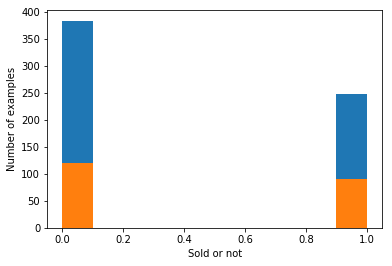

(633, 384) (211, 384)


In [106]:
# Display results
x_train, x_test, y_train, y_test = train_test_split(x, y)#, random_state=30)

plt.xlabel('Sold or not')
plt.ylabel('Number of examples')
plt.hist(y_train)
plt.hist(y_test)
plt.show()

print(x_train.shape, x_test.shape)

# Run training and plot results

In [119]:
clf = LogisticRegression(C=1, class_weight='balanced')

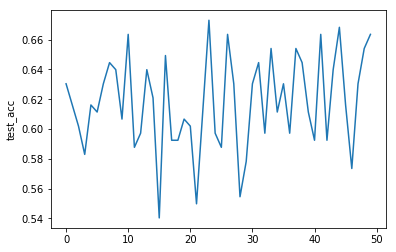

test acc : 0.618 ± 0.063
train acc : 0.840 ± 0.015


In [120]:
test_acc_list = []
train_acc_list = []

for seed in range(50):
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=seed)

    clf.fit(x_train, y_train)

    test_acc_list.append(clf.score(x_test, y_test))
    train_acc_list.append(clf.score(x_train, y_train))

plt.plot(range(50), test_acc_list)
plt.ylabel('test_acc')
plt.show()

test_acc_list = np.array(test_acc_list)
train_acc_list = np.array(train_acc_list)

mean_test_acc = test_acc_list.mean()
std_test_acc = test_acc_list.std()
mean_train_acc = train_acc_list.mean()
std_train_acc = train_acc_list.std()

print('test acc : {:.3f} ± {:.3f}'.format(mean_test_acc, std_test_acc * 2))
print('train acc : {:.3f} ± {:.3f}'.format(mean_train_acc, std_train_acc * 2))

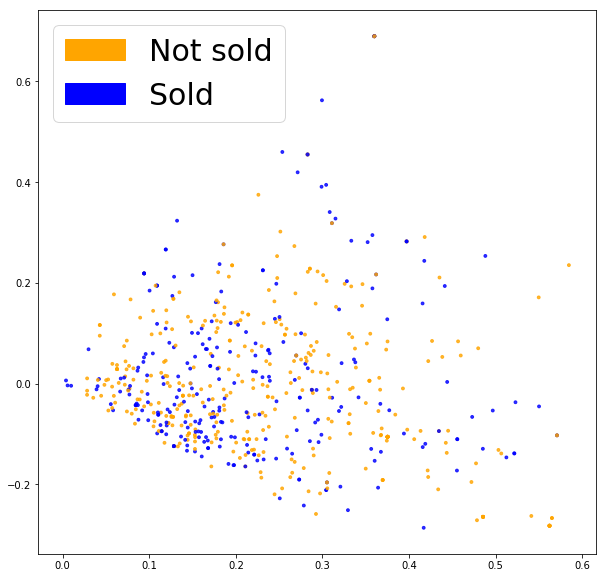

In [123]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(x_train, y_train)
plt.show()

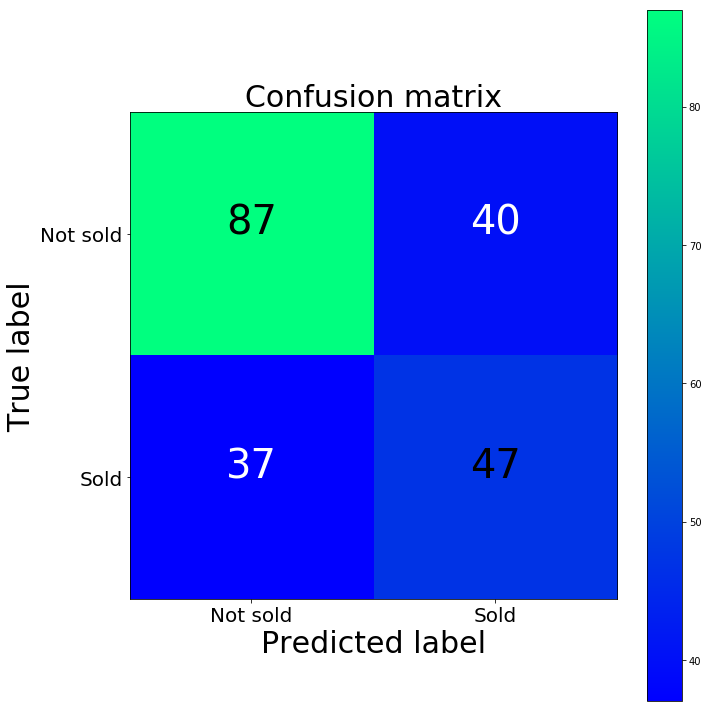

[[87 40]
 [37 47]]


In [117]:
cm = confusion_matrix(y_test, clf.predict(x_test))
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Not sold','Sold'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [103]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

NameError: name 'importance' is not defined